# Quantum Teleportation

This notebook demonstrates quantum teleportation. We first use Qiskit's built-in simulators to test our quantum circuit, and then try it out on a real quantum computer.

## Contents

1. [Overview](#overview)    
2. [The Quantum Teleportation Protocol](#how)       
3. [Simulating the Teleportation Protocol](#simulating)   
    3.1 [How will we Test this Result on a Real Quantum Computer?](#testing)   
    3.2 [Using the Simulated Statevector](#simulating-sv)     
    3.3 [Using the Simulated Counts](#simulating-fc)  
4. [Teleportation on a Real Quantum Computer](#real_qc)    
    4.1 [IBM hardware](#deferred-measurement)    

## 1. Overview <a id='overview'></a>

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the qubit state
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$. 
This entails passing on information about $\alpha$ and $\beta$ to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of $\vert\psi\rangle$ and give the copy to Bob. We can only copy classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer her state $\vert\psi\rangle$ to Bob. We call this teleportation because, at the end, Bob will have $\vert\psi\rangle$ and Alice won't anymore.

## 2. The Quantum Teleportation Protocol <a id='how'></a>
To transfer a quantum bit, Alice and Bob must use a third party (Telamon) to send them an entangled qubit pair. Alice then performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit.

We will describe the steps on a quantum circuit below. Here, no qubits are actually ‘sent’, you’ll just have to imagine that part!

First we set up our session:

In [37]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
#from qiskit import Aer     #puccj: with this, block 35 does not work
from qiskit.providers.aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector

and create our quantum circuit:

In [23]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

#### Step 1
A third party, Telamon, creates an entangled pair of qubits and gives one to Bob and one to Alice.

The pair Telamon creates is a special pair called a Bell pair. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis ($|+\rangle$ and $|-\rangle$) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis. 

In [24]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

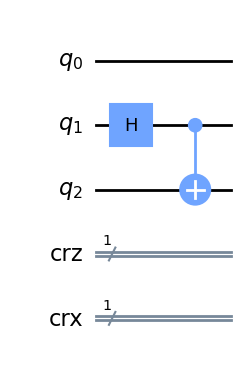

In [25]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw('mpl')

Let's say Alice owns $q_1$ and Bob owns $q_2$ after they part ways.

#### Step 2 

Alice applies a CNOT gate to $q_1$, controlled by $\vert\psi\rangle$ (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to $|\psi\rangle$. In our quantum circuit, the qubit ($|\psi\rangle$) Alice is trying to send is $q_0$:

In [26]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

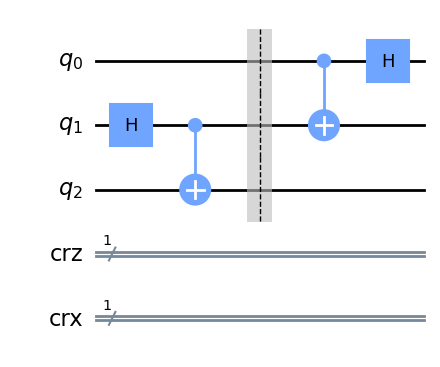

In [27]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw('mpl')

<b>-puccj- Notice the use of barrier:</b> <br>
qiskit will automatically try to merge things to create a more compact circuit. If you want to visually separate steps you can use barrier

#### Step 3

Next, Alice applies a measurement to both qubits that she owns, $q_1$ and $\vert\psi\rangle$, and stores this result in two classical bits. She then sends these two bits to Bob.

In [28]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

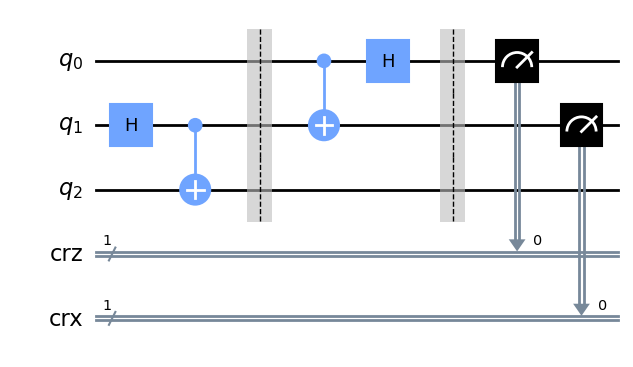

In [29]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw('mpl')

#### Step 4

Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

(*Note that this transfer of information is purely classical*.)

In [30]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

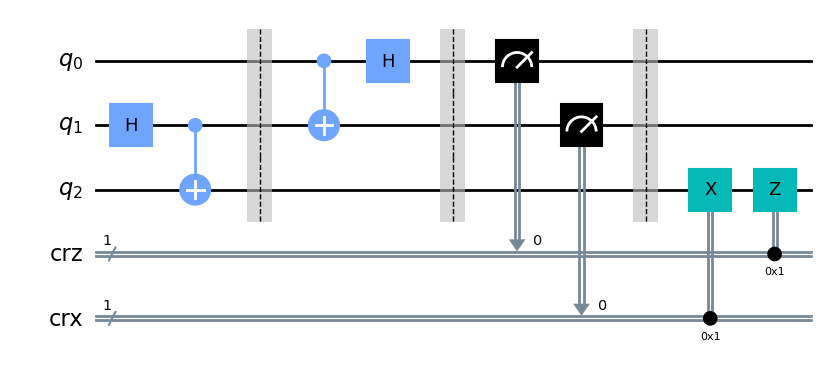

In [31]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw('mpl')

And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.

## 3. Simulating the Teleportation Protocol <a id='simulating'></a>

### 3.1 How Will We Test the Protocol on a Quantum Computer? <a id='testing'></a>

In this notebook, we will initialize Alice's qubit in a random state $\vert\psi\rangle$ (`psi`). This state will be created using an `Initialize` gate on $|q_0\rangle$. In this chapter we use the function `random_statevector` to choose `psi` for us, but feel free to set `psi` to any qubit state you want.

<IPython.core.display.Latex object>

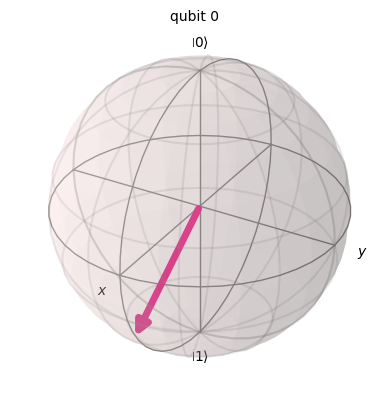

In [32]:
# Create random 1-qubit state
psi = random_statevector(2)

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

Let's create our initialization instruction to create $|\psi\rangle$ from the state $|0\rangle$:

In [33]:
init_gate = Initialize(psi)
init_gate.label = "init"

(`Initialize` is technically not a gate since it contains a reset operation, and so is not reversible. We call it an 'instruction' instead). If the quantum teleportation circuit works, then at the end of the circuit the qubit $|q_2\rangle$ will be in this state. We will check this using the statevector simulator.

### 3.2 Using the Simulated Statevector <a id='simulating-sv'></a>

We can use the Aer simulator to verify our qubit has been teleported.

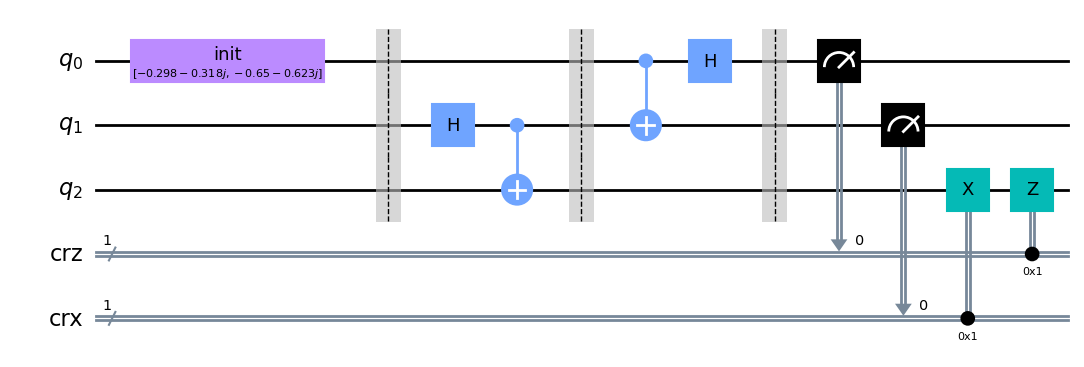

In [34]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw('mpl')

We can see below, using the statevector obtained from the aer simulator, that the state of $|q_2\rangle$ is the same as the state $|\psi\rangle$ we created above, while the states of $|q_0\rangle$ and $|q_1\rangle$ have been collapsed to either $|0\rangle$ or $|1\rangle$. The state $|\psi\rangle$ has been teleported from qubit 0 to qubit 2.

In [35]:
# Save statevector at the end of the circuit
qc.save_statevector()

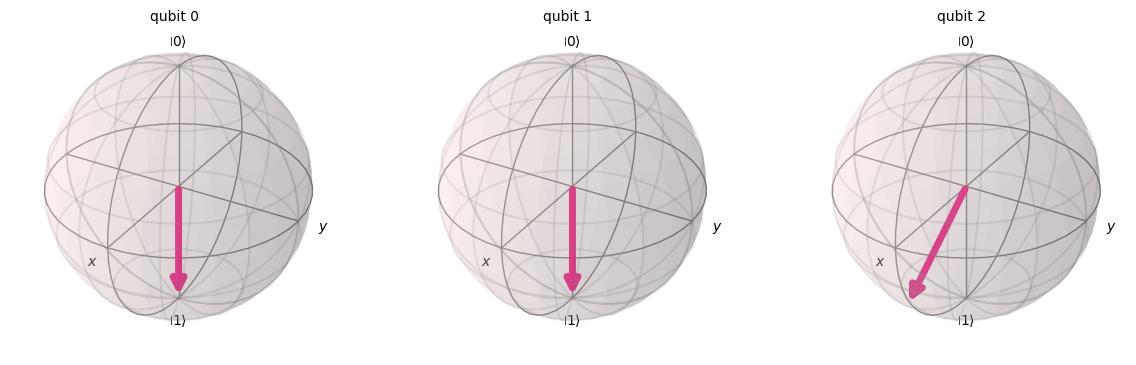

In [38]:
# Run circuit on the AerSimulator

simulator = Aer.get_backend('aer_simulator')

# Run qc, the output is a job object
job = simulator.run(qc)

# Extract result from job
result = job.result()

# Get previously saved statevector and plot it
out_vector = result.get_statevector()
plot_bloch_multivector(out_vector)

You can run this cell a few times to make sure. You may notice that the qubits 0 & 1 change states, but qubit 2 is always in the state $|\psi\rangle$.

### 3.3 Using the Simulated Counts <a id='simulating-fc'></a>

In many cases, including when using real hardware, we don't have access to the statevector of the system. In those cases, we can hope to verify that our protocol has worked properly by repeating the circuit execution $N_{shots}$ times, and performing a measurement of Bob's qubit at the end of each execution.

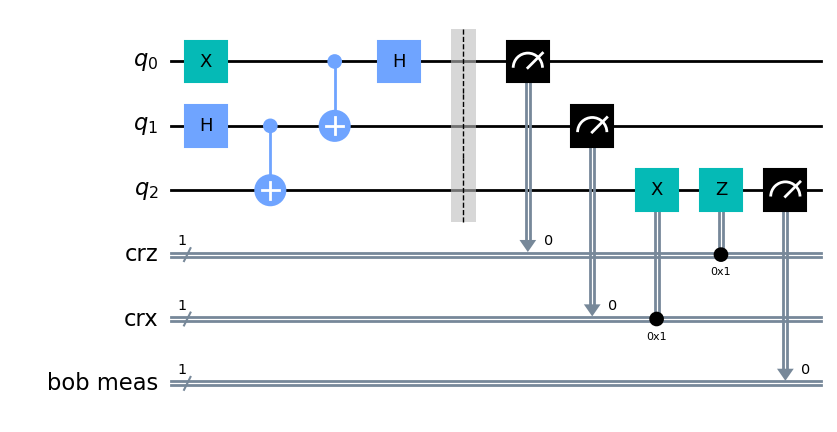

In [39]:
# Initialize new quantum teleportation circuit

qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 3 classical registers, 2 for teleportation and 1 for final measurement
crx = ClassicalRegister(1, name="crx")
bm = ClassicalRegister(1, name='bob meas')
qc_meas = QuantumCircuit(qr, crz, crx, bm)

# Alice's q0, here we set it to |1> for simplicity
qc_meas.x(0)

# Teleportation protocol
create_bell_pair(qc_meas, 1, 2)
alice_gates(qc_meas, 0, 1)
measure_and_send(qc_meas, 0, 1)
bob_gates(qc_meas, 2, crz, crx)

# Measurement of Bob's q2, should always give 1
qc_meas.measure(2, bm)

qc_meas.draw('mpl')

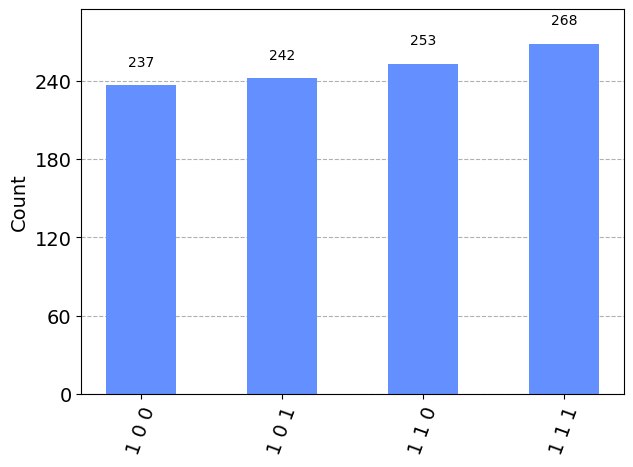

In [40]:
# Run circuit on the AerSimulator, with N_shots = 1000 measurements

simulator = Aer.get_backend('aer_simulator')
N_shots = 1000
job = simulator.run(qc_meas, shots = N_shots)

# Extract result from job
result = job.result()

# Extract outcomes and construct histogram
counts = result.get_counts()
plot_histogram(counts)

We can see that the most significant bit (i.e. the leftmost one, corresponding to qubit $q_2$) is always 1, meaning we have a 100% chance of measuring $q_2$ in the state $|1\rangle$. This is the expected result, and indicates the teleportation protocol has worked properly.

## 4. Teleportation on a Real Quantum Computer <a id='real_qc'></a>

### 4.1 IBM hardware <a id='deferred-measurement'></a>

To access IBM hardware we need to install `qiskit-ibm-provider`, which can be done through `pip`:

```
pip install qiskit-ibm-provider
```

We can then import the corresponding modules, and activate our account with the API token found in https://quantum-computing.ibm.com :

In [50]:
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit import transpile

# Save account credentials. This is necessary only the first time.
# puccj: read token from 'token.txt' file (I didn't want to have it public on GitHub)
try:
    with open('token.txt', 'r') as file:
        IBMProvider.save_account(token=file.read())   #puccj: if you make an error and insert a wrong token, just add "overwrite = True" to correct it
except FileNotFoundError:
    print("\033[91m\033[1m File token.txt not found. Ignoring creation of new account and trying just to load it. \033[0m")

# Load previously saved account credentials.
provider = IBMProvider()

Before the execution on a given device, circuits need to be adapted so that they are compatible with that device. For example, all the gates used must be re-expressed through the universal gate set used by the machine. This process is called transpiling, and it is performed automatically by Qiskit's [transpiler](https://qiskit.org/documentation/apidoc/transpiler.html).
A list of all the backends we can use can be found [here](https://quantum-computing.ibm.com/services/resources?tab=yours).

In [55]:
# Select which backend to use

# Select a specific backend ("ibm_lagos")
backend = provider.get_backend("ibm_lagos")

# Select the least busy backend
# backend = least_busy(provider.backends(simulator=False, operational=True, dynamic_circuits=True, n_qubits = 7))

# Select a simulator
# backend = provider.get_backend("ibmq_qasm_simulator")

# Printing backend name
print(backend.name)

ibm_lagos


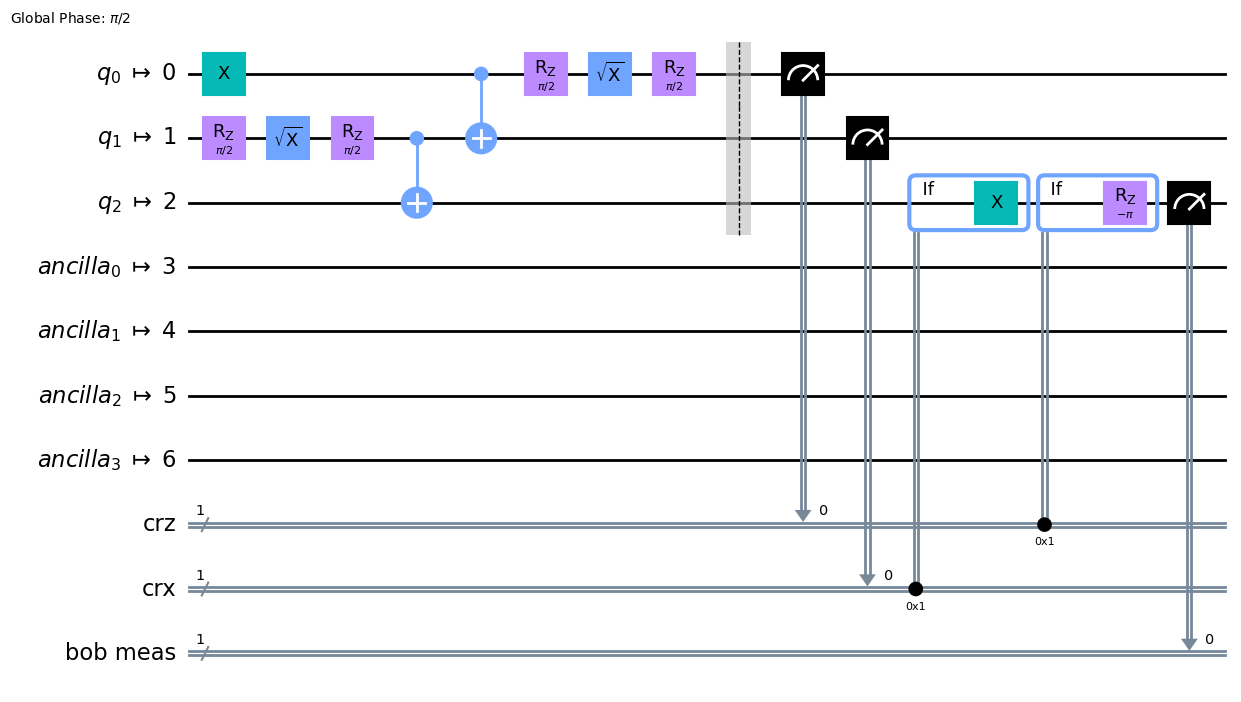

In [56]:
# Transpiling the qc_meas circuit to the given backend
tqc = transpile(qc_meas, backend=backend)
tqc.draw('mpl')

At this point, we can run the transpiled circuit on the backend as we did for the simulator.

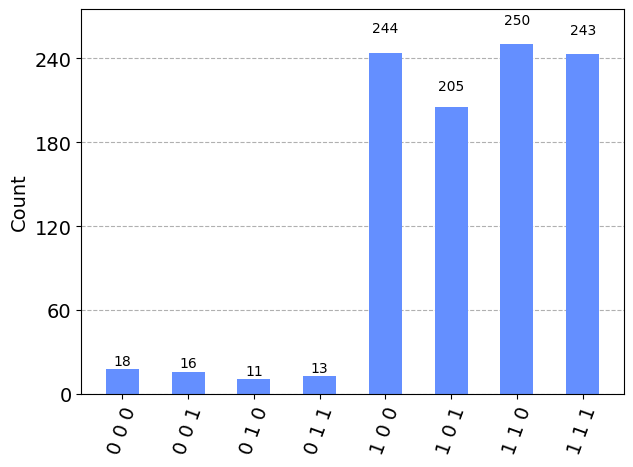

In [57]:
# Running the circuit 1000 times

job = backend.run(tqc, shots = 1000, dynamic=True)
result = job.result()

# Extracting outcomes and constructing histogram
counts = result.get_counts()
plot_histogram(counts)

As we see here, there are a few results in which $q_2$ was measured in $|0\rangle$. These arise due to errors in the gates and the qubits. In contrast, our simulator in the earlier part of the notebook had zero errors in its gates, and allowed error-free teleportation.

In [59]:
counts

{'0 0 0': 18,
 '0 0 1': 16,
 '0 1 0': 11,
 '0 1 1': 13,
 '1 0 0': 244,
 '1 0 1': 205,
 '1 1 0': 250,
 '1 1 1': 243}

## 5. Exercises <a id='exercises'></a>
1. How can you estimate the fidelity of the noisy execution? 

2. The deferred measurement principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results:
![defer_measurement.svg](images\defer_measurement.svg)
Construct a completely unitary version of the protocol by replacing all classical conditional measurements with quantum controlled gates, then run it on a real device. Is the fidelity worse or better? Why?

In [61]:
import qiskit.tools.jupyter
%qiskit_version_table